
# Very-high-energy gamma-ray data analysis

**Objectives:**
- Create a 3D dataset (lon, lat, energy) of the SNR RXJ 1713.7-3946 using the H.E.S.S. DL3 data release 1
- Load source models from H.E.S.S HGPS and Fermi-LAT 4FGL catalogues
- Perform a fit of the source 
- Simulate CTAO observations


## Setup

First, we setup the analysis by performing required imports.


In [1]:
import numpy as np
from pathlib import Path
from astropy import units as u
from astropy.coordinates import SkyCoord
from regions import CircleSkyRegion, Regions

# %matplotlib inline
import matplotlib.pyplot as plt
from gammapy.data import DataStore
from gammapy.datasets import MapDataset
from gammapy.estimators import FluxPointsEstimator
from gammapy.makers import FoVBackgroundMaker, MapDatasetMaker, SafeMaskMaker
from gammapy.maps import MapAxis, WcsGeom
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    FoVBackgroundModel,
    PointSpatialModel,
    PowerLawSpectralModel,
    PowerLawNormSpectralModel,
    SkyModel,
)
from gammapy.utils.check import check_tutorials_setup
from gammapy.visualization import plot_npred_signal

## Check setup



In [2]:
#check_tutorials_setup()

## Defining the datastore and selecting observations

We first use the `~gammapy.data.DataStore` object to access the
observations we want to analyse. Here the H.E.S.S. DL3 DR1.




In [3]:
data_store = DataStore.from_dir("$GAMMAPY_DATA/hess-dl3-dr1")

We can now define an observation filter to select only the relevant
observations. Here we use a cone search which we define with a python
dict.

We then filter the `ObservationTable` with
`~gammapy.data.ObservationTable.select_observations`.




In [4]:
#data_store.obs_table.keys()


In [5]:
#data_store.obs_table


In [6]:
selection = data_store.obs_table["OBJECT"]=="RXJ 1713.7-3946"

We can now retrieve the relevant observations by passing their
``obs_id`` to the `~gammapy.data.DataStore.get_observations`
method.




In [7]:

obs_ids = data_store.obs_table["OBS_ID"][selection]
observations = data_store.get_observations(obs_ids)

In [8]:
#print(observations)

Let's look at the content one obervation

In [9]:
obs = observations[0]

### Events

In [10]:
obs.events.table[:5]

EVENT_ID,TIME,RA,DEC,ENERGY
,s,deg,deg,TeV
int64,float64,float32,float32,float32
21603685498902,103858277.75790691,257.38425,-39.32344,0.8007868
21603685499034,103858278.07311487,257.71066,-40.528507,0.22329243
21603685499048,103858278.0907073,259.5841,-41.132343,0.348764
21603685499084,103858278.21556139,257.3364,-38.862774,0.23064576
21603685499112,103858278.27913809,257.5447,-40.445763,0.89308655


### Instrument response functions: IRFs

/Users/qremy/anaconda3/envs/gpy-dev/lib/python3.11/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


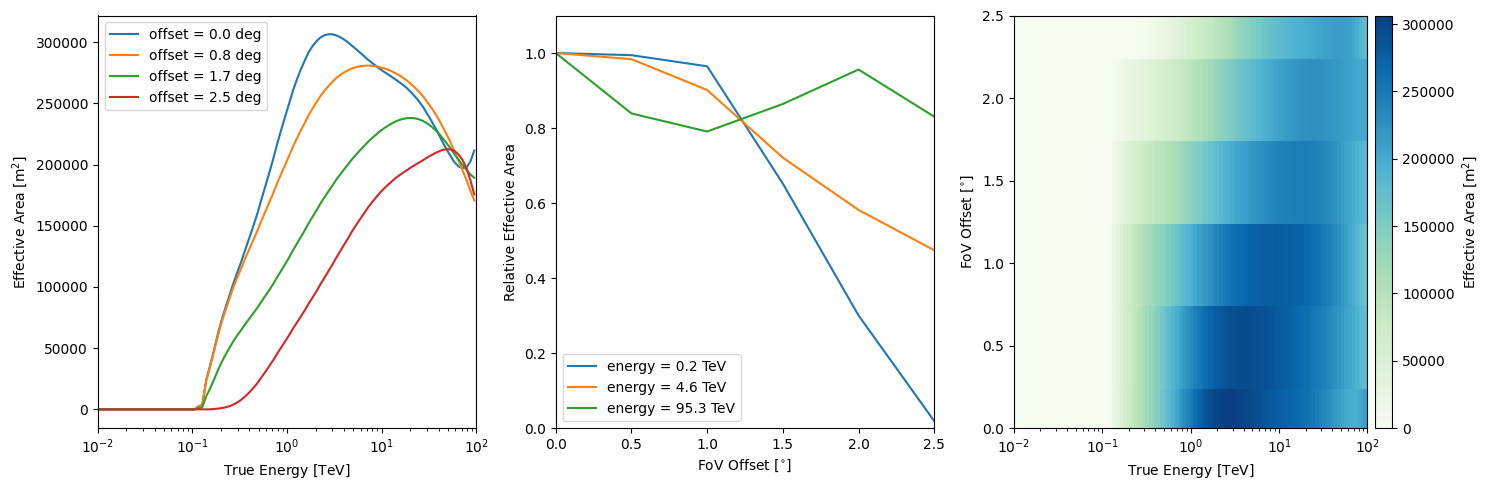

In [11]:
#Effective area
obs.aeff.peek()

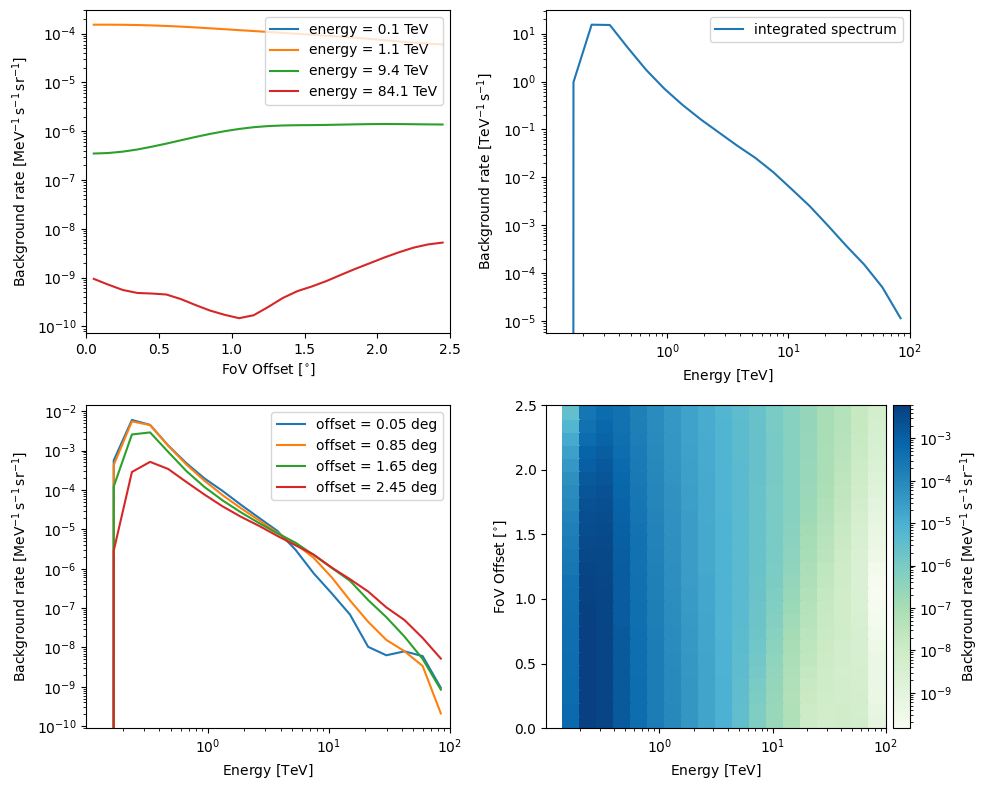

In [12]:
#Background rate
obs.bkg.peek()

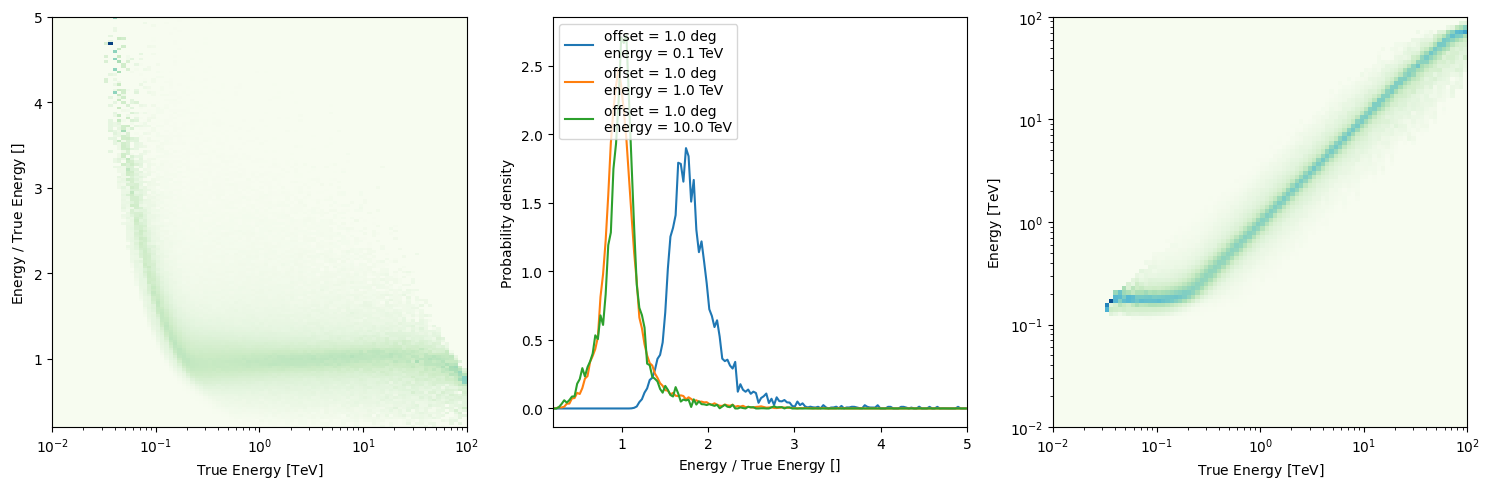

In [13]:
#Energy dispersion
obs.edisp.peek()

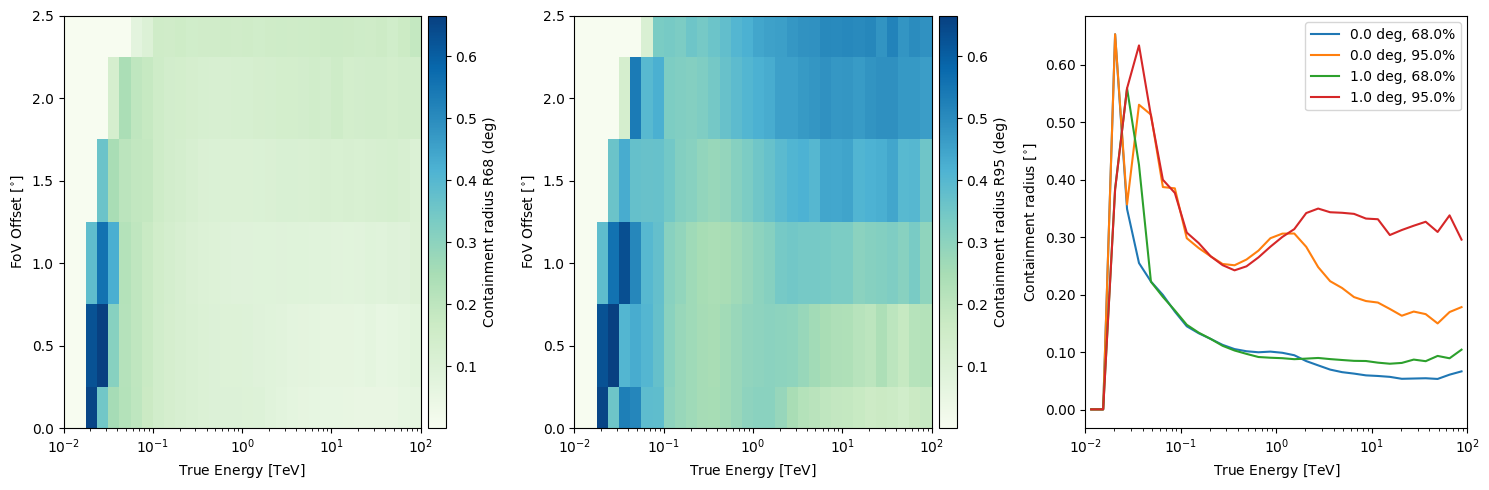

In [14]:
#Point Spread Function
obs.psf.peek()

In [15]:
print(obs.psf.info(
      fraction=[0.68, 0.99, 0.68, 0.99],
      energy_true=[1., 1., 10, 10]*u.TeV,
      offset=[0, 0, 0, 0]*u.deg)
     )


Summary PSF info
----------------
Theta          : size =     6, min =  0.000 deg, max =  2.500 deg
Energy hi      : size =    32, min =  0.013 TeV, max = 100.000 TeV
Energy lo      : size =    32, min =  0.010 TeV, max = 74.989 TeV
68.00 containment radius at offset = 0.0 deg and energy_true =  1.0 TeV: 0.100 deg
99.00 containment radius at offset = 0.0 deg and energy_true =  1.0 TeV: 0.500 deg
68.00 containment radius at offset = 0.0 deg and energy_true = 10.0 TeV: 0.059 deg
99.00 containment radius at offset = 0.0 deg and energy_true = 10.0 TeV: 0.306 deg



## Preparing reduced datasets geometry

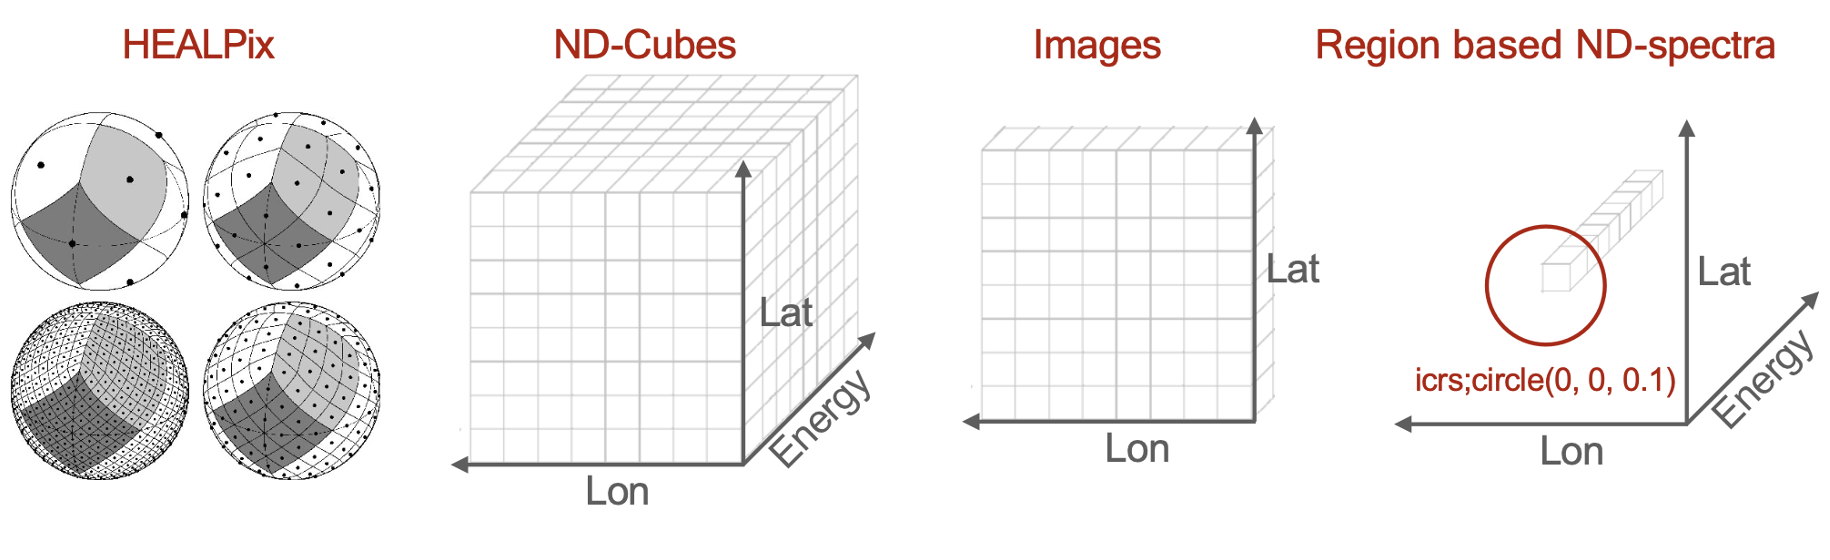

Now we define a reference geometry for our analysis, We choose a WCS
based geometry with a binsize of 0.02 deg and also define an energy
axis:




In [16]:
energy_axis = MapAxis.from_energy_bounds(0.5, 50, 5, per_decade=True, unit="TeV")
position = SkyCoord.from_name("HESS J1713-397").galactic

geom = WcsGeom.create(
    skydir=position,
    binsz=0.02,
    width=(4, 3),
    frame="galactic",
    proj="CAR",
    axes=[energy_axis],
)
geom_image = geom.to_image()

# Reduced IRFs are defined in true energy (i.e. not measured energy).
energy_axis_true = MapAxis.from_energy_bounds(
    0.1, 100, 10, per_decade=True, unit="TeV", name="energy_true"
)

Now we can define the target dataset with this geometry.




In [17]:
empty_dataset = MapDataset.create(
    geom=geom, energy_axis_true=energy_axis_true, name="RXJ-HESS"
)

## Data reduction

### Create the maker classes to be used

The `~gammapy.makers.MapDatasetMaker` create an empty dataset.


In [18]:
maker_dataset = MapDatasetMaker()


The `~gammapy.makers.SafeMaskMaker` determines the safe analysis region here a maximum offset and a minimal effective area 
selection.

In [19]:
offset_max = 2. * u.deg
maker_safe_mask = SafeMaskMaker(
    methods=["offset-max", "aeff-max", "bkg-peak"], offset_max=offset_max, aeff_percent=10
)


The `~gammapy.makers.FoVBackgroundMaker` fit the bakground model normalisation in source-free regions outside of the **exlusion mask**.
This mask typically exclude a band along the Galactic plane known sources


In [20]:
# masking galactic plane
from regions import Regions
ds9_box = "galactic;box(0,0,180,1, 0)"
regions = Regions.parse(ds9_box, format="ds9")
galaxy_mask = geom_image.region_mask(regions)


In [21]:
# masking known sources
from gammapy.catalog import CATALOG_REGISTRY
hgps = CATALOG_REGISTRY.get_cls("hgps")() #load HGPS catalog


In [22]:
inside_geom = geom.to_image().contains(hgps.positions)
hgps = hgps[inside_geom]

In [23]:
hgps_models_roi = hgps.to_models()
source_mask = geom_image.region_mask(hgps_models_roi.to_regions())
source_mask = source_mask.binary_dilate(0.5*u.deg) # extend the mask considering the size of the PSF

In [24]:
exclusion_mask = ~(galaxy_mask | source_mask)

<WCSAxes: >

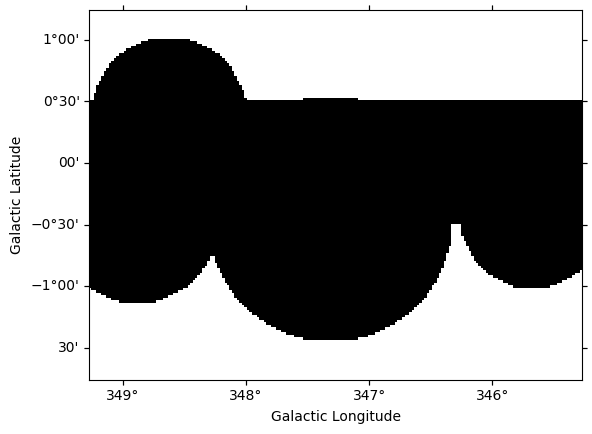

In [25]:
exclusion_mask.plot()

Now we define the background maker

In [26]:
maker_fov_bkg = FoVBackgroundMaker(method="fit", exclusion_mask=exclusion_mask)

The makers will be applyied sequentially so the order matter :

In [27]:
makers = [maker_dataset, maker_safe_mask, maker_fov_bkg]

### Perform the data reduction loop




In [28]:
%%time
from gammapy.makers import DatasetsMaker
datasets_maker = DatasetsMaker(makers, stack_datasets=True, n_jobs=3)

datasets = datasets_maker.run(empty_dataset, observations)

dataset = datasets[0]

CPU times: user 698 ms, sys: 387 ms, total: 1.08 s
Wall time: 6.01 s


### Inspect the reduced dataset




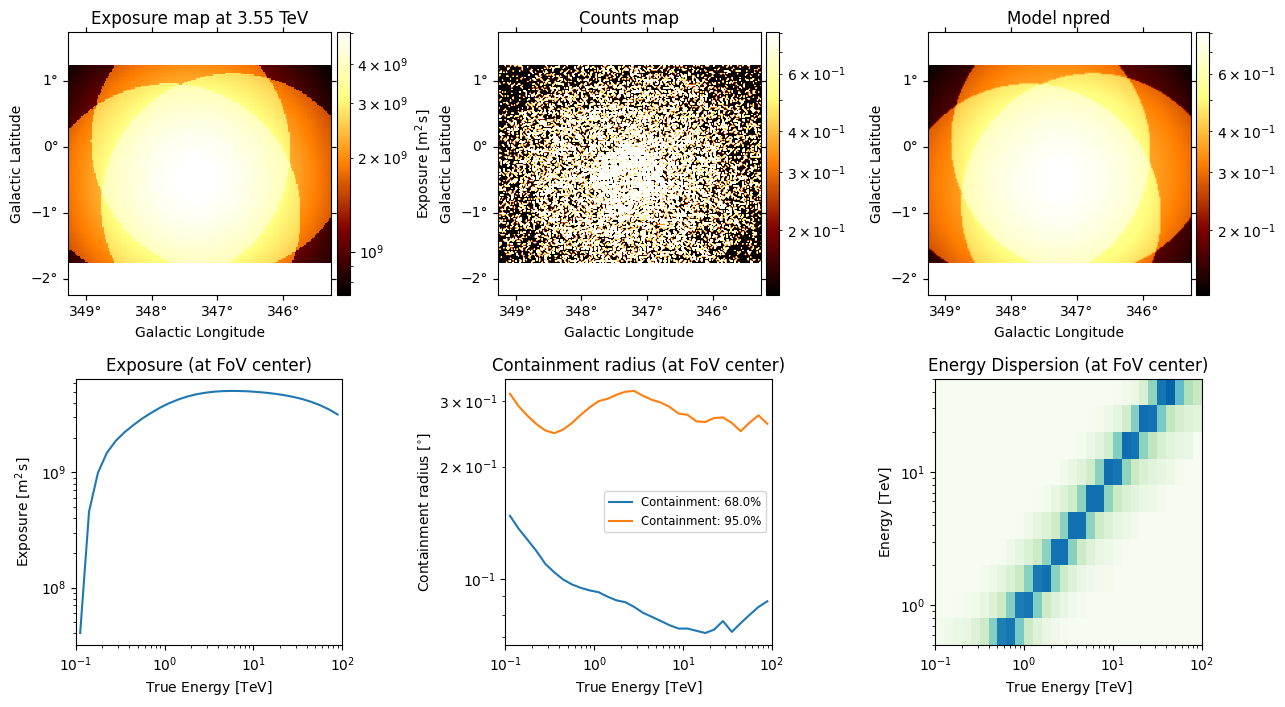

In [29]:
dataset.peek()

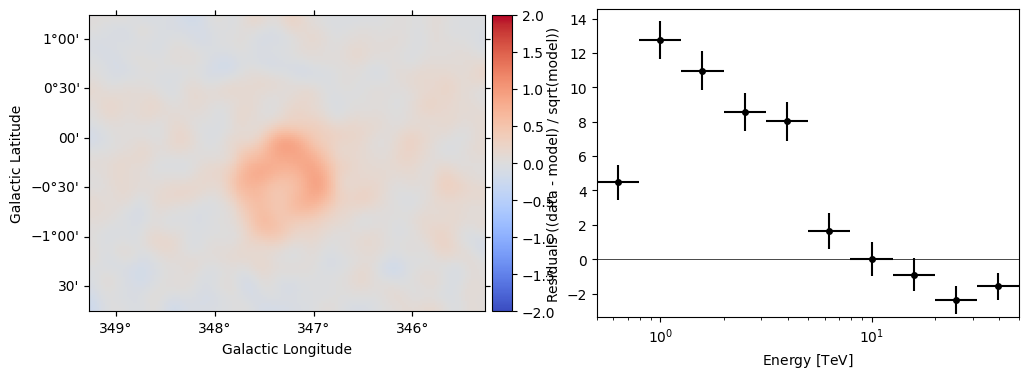

In [30]:
dataset.plot_residuals(
    kwargs_spatial=dict(method="diff/sqrt(model)", vmin=-2, vmax=2),
    kwargs_spectral=dict(method="diff/sqrt(model)"),
)
plt.show()

We can make also use the ~gammapy.estimators.TSMapEstimator get a map of the test statistic (TS) between two hypothesis : the best-fit flux model (assuming a given spatial shape and spectral index) and the null model (flux=0 i.e no source).

In [31]:
from gammapy.estimators import  TSMapEstimator
from gammapy.modeling.models import PointSpatialModel, PowerLawSpectralModel
spatial_model = PointSpatialModel()
spectral_model = PowerLawSpectralModel(index=2)
model = SkyModel(spatial_model=spatial_model, spectral_model=spectral_model)

ts_estimator = TSMapEstimator(
    model,
    kernel_width="0.5 deg",#this set close to the 95-99% containment radius of the PSF
    selection_optional=[],
    sum_over_energy_groups=True,
    energy_edges=[1, 10] * u.TeV,
    n_jobs=3
)

In [32]:
%%time
ts_results = ts_estimator.run(dataset)

CPU times: user 1.17 s, sys: 131 ms, total: 1.31 s
Wall time: 3.86 s


Let's define a function to make an objectively pretty plot



In [33]:
import matplotlib as mpl

def plot_significance_map(estimator_results, source_models=None):
    fig = plt.figure(figsize=(11,4), dpi=130)
    ax = estimator_results["sqrt_ts"].plot(clim=[-8,8], cmap=plt.cm.RdBu_r)
    im = [obj for obj in ax.get_children() if isinstance(obj, mpl.image.AxesImage)][0]
    if source_models:
        source_models.plot_regions(ax=ax, edgecolor="g", linestyle="-", kwargs_point=dict(marker="."))
    plt.title(r"$\sqrt{TS}$", loc="left", fontsize=12, pad=10)
    cb_ax = fig.add_axes([.55, .91, .15, 0.04])
    cb = fig.colorbar(im, cax=cb_ax, orientation='horizontal')  
    cb.ax.xaxis.set_ticks_position("top")
    cb.ax.xaxis.set_label_position("top")
    cb.ax.tick_params(axis="both", which="major", labelsize=12)
    cb.ax.set_xlabel(r"[$\sigma$]", fontsize=12, labelpad=-28, x=-0.1);

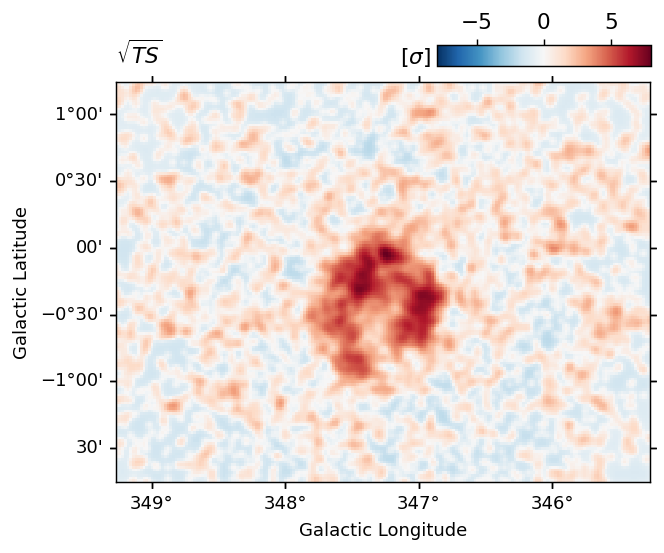

In [34]:
plot_significance_map(ts_results)

## Save dataset to disk

It is common to run the preparation step independent of the likelihood
fit, because often the preparation of maps, PSF and energy dispersion is
slow if you have a lot of data. We first create a folder:




In [35]:
path = Path("analysis")
path.mkdir(exist_ok=True)

And then write the maps and IRFs to disk by calling the dedicated
`~gammapy.datasets.MapDataset.write` method:




In [80]:
from gammapy.datasets import Datasets
filename = path / "RXJ-HESS-datasets.yaml"
datasets.write(filename, overwrite=True)

#datasets = Datasets.read(filename)

/Users/qremy/Work/GitHub/gammapy/gammapy/utils/scripts.py:72: UserWarning: Checksum verification failed.
  warnings.warn("Checksum verification failed.", UserWarning)


In [37]:
!cat  analysis/RXJ-HESS-datasets.yaml

datasets:
-   name: RXJ-HESS
    type: MapDataset
    filename: RXJ-HESS.fits
metadata:
    creator: Gammapy 2.0.dev508+gdff7174b0.d20250221
    date: '2025-06-25T13:53:22.699384'
    origin: null


## Define the model

We first define the model, a `~gammapy.modeling.models.SkyModel`, as the combination of a point
source `~gammapy.modeling.models.SpatialModel` with a powerlaw `~gammapy.modeling.models.SpectralModel`.
For this example we are going to load the models from the catalogs.

We can load the model from Fermi-LAT catalog and refit it on H.E.S.S. data

In [38]:
fgl4 = CATALOG_REGISTRY.get_cls("4fgl")() #load HGPS catalog
#inside_geom = geom.to_image().contains(fgl4.positions)
#fgl4 = fgl4[inside_geom]


In [39]:
#fgl4.table

In [40]:
#here we pick the model and flux points of our source of interest
rxj_fermi_model = fgl4["4FGL J1713.5-3945e"].sky_model()
rxj_fermi_fp = fgl4["4FGL J1713.5-3945e"].flux_points

In [41]:
#we make a copy
rxj_skymodel = rxj_fermi_model.copy(name="RXJ1713")
amplitude_1TeV = rxj_skymodel.spectral_model(1*u.TeV)
#and change the energy reference to be in H.E.S.S. energy range
rxj_skymodel.spectral_model.amplitude.quantity = amplitude_1TeV
rxj_skymodel.spectral_model.reference.quantity = 1*u.TeV

We are going to add the other sources in the region from the H.E.S.S catalog

In [42]:
print(hgps_models_roi.names)

['HESS J1708-410', 'HESS J1713-381', 'HESS J1713-397', 'HGPSC 045', 'HESS J1718-385']


In [43]:
hgps_models_roi.freeze() #here we freeze the parameters of other sources for simplicity

We remove our source of interest for which we already have a model from Fermi-LAT

In [44]:
hgps_models_roi.remove("HESS J1713-397")

We define a FoVBackgroundModel which allow to rescale the background

In [45]:
bkg_model = FoVBackgroundModel(dataset_name=dataset.name)


Now we assign these models to our reduced dataset:




In [46]:
dataset.models = hgps_models_roi + [rxj_skymodel, bkg_model]

## Fit the model

The `~gammapy.modeling.Fit` class is orchestrating the fit, connecting
the ``stats`` method of the dataset to the minimizer. By default, it
uses ``iminuit``.

Its constructor takes a list of dataset as argument.




In [47]:
%%time
fit = Fit(optimize_opts=dict(strategy=1, tol=0.1)) #print_level=1
result = fit.run([dataset])

CPU times: user 3.18 s, sys: 59.5 ms, total: 3.24 s
Wall time: 3.24 s


The `~gammapy.modeling.FitResult` contains information about the optimization and
parameter error calculation.




In [48]:
print(result)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 141
	total stat : 105463.62

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



In [49]:
result.minuit

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.055e+05                  │              Nfcn = 141              │
│ EDM = 1.53e-06 (Goal: 0.0002)    │            time = 3.2 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name              │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ par_000_amplitude │   2.11    │   0.11    │            │            │         │         │       │
│ 1 │ par_001_alpha     │   1.91    │   0.09    │            │            │         │         │       │
│ 2 │ par_002_beta      │    18     │     5     │            │            │         │         │       │
│ 3 │ par_003_norm      │   1.040   │   0.009   │            │            │         │         │       │
└───┴───────────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────────────────┬─────────────────────────────────────────────────────────────────────────┐
│                   │ par_000_amplitude     par_001_alpha      par_002_beta      par_003_norm │
├───────────────────┼─────────────────────────────────────────────────────────────────────────┤
│ par_000_amplitude │            0.0115             0.001             0.105          -0.26e-3 │
│     par_001_alpha │             0.001           0.00864            -0.367          -0.08e-3 │
│      par_002_beta │             0.105            -0.367                25           2.25e-3 │
│      par_003_norm │          -0.26e-3          -0.08e-3           2.25e-3           7.8e-05 │
└───────────────────┴─────────────────────────────────────────────────────────────────────────┘

The fitted parameters are visible from the
`~astropy.modeling.models.Models` object.




In [50]:
dataset.models.to_parameters_table()

model,type,name,value,unit,error,min,max,frozen,link,prior
str14,str1,str9,float64,str14,float64,float64,float64,bool,str1,str1
HESS J1708-410,,index,2.5428e+00,,0.000e+00,nan,nan,True,,
HESS J1708-410,,amplitude,8.8776e-13,TeV-1 s-1 cm-2,0.000e+00,nan,nan,True,,
HESS J1708-410,,reference,1.0503e+00,TeV,0.000e+00,nan,nan,True,,
HESS J1708-410,,lon_0,3.4567e+02,deg,0.000e+00,nan,nan,True,,
HESS J1708-410,,lat_0,-4.3589e-01,deg,0.000e+00,-9.000e+01,9.000e+01,True,,
HESS J1708-410,,sigma,6.3760e-02,deg,0.000e+00,0.000e+00,nan,True,,
HESS J1708-410,,e,0.0000e+00,,0.000e+00,0.000e+00,1.000e+00,True,,
HESS J1708-410,,phi,0.0000e+00,deg,0.000e+00,-1.800e+02,1.800e+02,True,,
HESS J1713-381,,index,2.7379e+00,,0.000e+00,nan,nan,True,,


### Inspecting residuals

For any fit it is useful to inspect the residual images. We have a few
options on the dataset object to handle this. First we can use
`~gammapy.datasets.MapDataset.plot_residuals_spatial` to plot a residual image, summed over all
energies:




ax = dataset.plot_residuals_spatial(method="diff/sqrt(model)", vmin=-2, vmax=2)
plt.show()

We can also compute the residual TS map

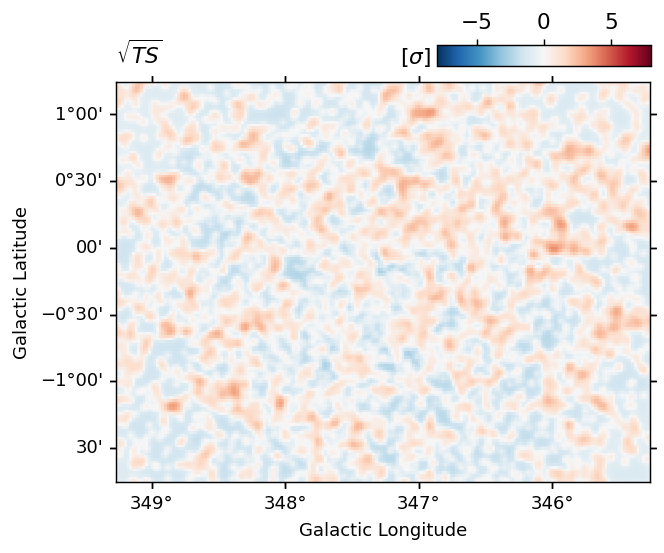

In [81]:
ts_results_after_fit = ts_estimator.run(dataset)
plot_significance_map(ts_results_after_fit)

## Plot the fitted spectrum




### Making a butterfly plot

The `~gammapy.modeling.models.SpectralModel` component can be used to produce a, so-called,
butterfly plot showing the envelope of the model taking into account
parameter uncertainties:




In [52]:
rxj_spec_fermi = rxj_fermi_model.spectral_model
rxj_spec_hess = rxj_skymodel.spectral_model.copy()


Now we can actually do the plot using the ``plot_error`` method:




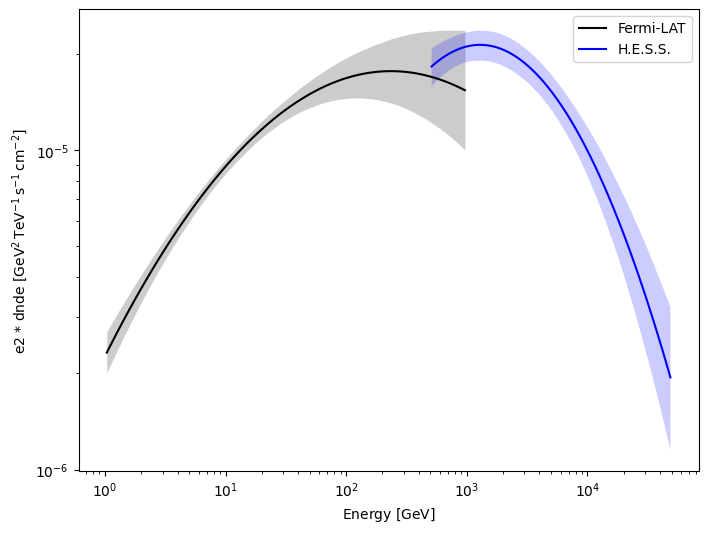

In [53]:
energy_bounds_fermi = [1, 1000]*u.GeV
energy_bounds_hess = [0.5, 50]*u.TeV
energy_bounds = [1, 5e4]*u.GeV

fig, ax = plt.subplots(figsize=(8, 6))

rxj_spec_fermi.plot(ax=ax, energy_bounds=energy_bounds_fermi, energy_power=2, color="k", label="Fermi-LAT")
rxj_spec_fermi.plot_error(ax=ax, energy_bounds=energy_bounds_fermi, energy_power=2, color="k")

rxj_spec_hess.plot(ax=ax, energy_bounds=energy_bounds_hess, energy_power=2, color="b", label="H.E.S.S.")
rxj_spec_hess.plot_error(ax=ax, energy_bounds=energy_bounds_hess, energy_power=2, facecolor="b")

plt.legend()
plt.show()

### Computing flux points

We can now compute some flux points using the
`~gammapy.estimators.FluxPointsEstimator`.

Besides the list of datasets to use, we must provide it the energy
intervals on which to compute flux points as well as the model component
name.




In [54]:
energy_edges = [0.5, 1, 5, 10, 50] * u.TeV
fpe = FluxPointsEstimator(energy_edges=energy_edges, source="RXJ1713")

In [55]:
rxj_hess_fp = fpe.run(datasets=datasets)


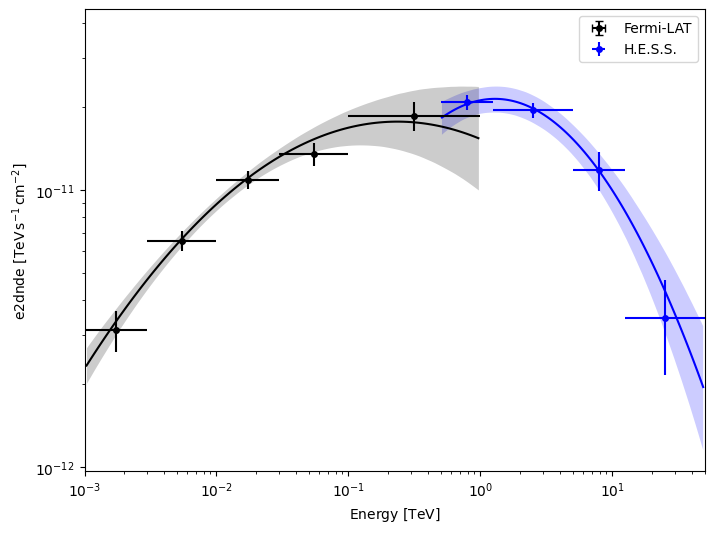

In [56]:
fig, ax = plt.subplots(figsize=(8, 6))

rxj_spec_hess.plot(ax=ax, energy_bounds=energy_bounds_hess, energy_power=2, color="b")
rxj_spec_hess.plot_error(ax=ax, energy_bounds=energy_bounds_hess, energy_power=2, facecolor="b")

rxj_spec_fermi.plot(ax=ax, energy_bounds=energy_bounds_fermi, energy_power=2, color="k")
rxj_spec_fermi.plot_error(ax=ax, energy_bounds=energy_bounds_fermi, energy_power=2, color="k")
rxj_fermi_fp.plot(ax=ax, sed_type="e2dnde", color="k", label="Fermi-LAT")
rxj_hess_fp.plot(ax=ax, sed_type="e2dnde", color="b", label="H.E.S.S.")
plt.xlim(energy_bounds)
plt.legend()
plt.show()

## Combined fit


Now let's fit both instruments together.

Here for simplicity we create `FluxPointsDataset` from Fermi-lAT points but we could also donwload the data, create a MapDataset and do joint fit avec the full data of Fermi-lAT and H.E.S.S.

In [57]:
from gammapy.datasets import FluxPointsDataset
fermi_fp_dataset = FluxPointsDataset(data=rxj_fermi_fp)


We define a new sepctral model (more flexible to fit the data over a broad energy range) and keep the same spatial template

In [58]:
from gammapy.modeling.models import ExpCutoffPowerLawNormSpectralModel

spectral_model = rxj_skymodel.spectral_model.copy()
cutoff = ExpCutoffPowerLawNormSpectralModel()
cutoff.norm.frozen=True
spectral_model *= cutoff

spatial_model = rxj_skymodel.spatial_model 

rxj_combined = SkyModel(spectral_model=spectral_model,
                        spatial_model=spatial_model,
                        name="rxj_combined" )

In [59]:
fermi_fp_dataset.models = rxj_combined
dataset.models =  hgps_models_roi + [rxj_combined, bkg_model]

In [60]:
%%time
result_combined = fit.run([dataset, fermi_fp_dataset])

CPU times: user 18.3 s, sys: 257 ms, total: 18.6 s
Wall time: 18.6 s


In [61]:
print(result_combined)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully, but uncertainties are unreliable.
	nfev       : 344
	total stat : 105467.91

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



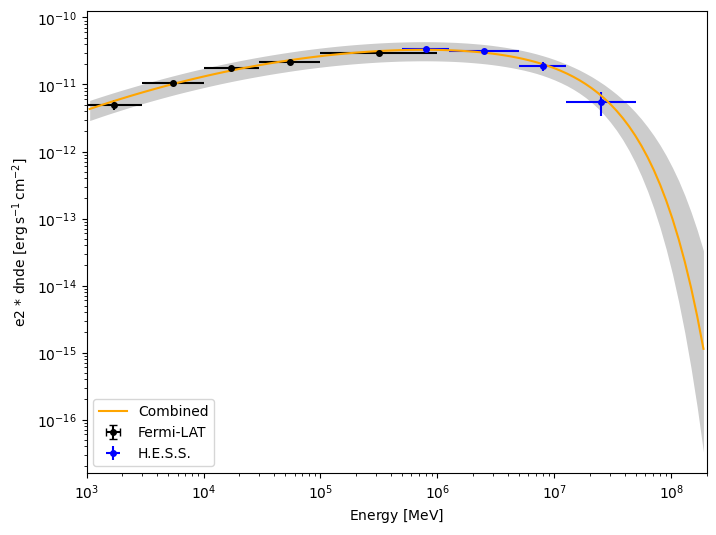

In [78]:
fig, ax = plt.subplots(figsize=(8, 6))

rxj_fermi_fp.plot(ax=ax, sed_type="e2dnde", color="k", label="Fermi-LAT")
rxj_hess_fp.plot(ax=ax, sed_type="e2dnde", color="b", label="H.E.S.S.")

rxj_combined.spectral_model.plot(ax=ax, energy_bounds=energy_bounds, energy_power=2, color="orange", label="Combined")
rxj_combined.spectral_model.plot_error(ax=ax, energy_bounds=energy_bounds, energy_power=2, color="orange")

plt.xlim(energy_bounds)
plt.legend()
plt.show()

## What the future instruments will see ?

Now we can make a simple simulation of our region using CTAO IRFs shipped with gammapy.


In [63]:
from gammapy.irf import load_irf_dict_from_file
# Loading IRFs
irfs = load_irf_dict_from_file(
    "$GAMMAPY_DATA/cta-caldb/Prod5-South-20deg-AverageAz-14MSTs37SSTs.180000s-v0.1.fits.gz"
)


Define the observation parameters (typically the observation duration and the pointing position):


In [64]:
from gammapy.data import Observation, observatory_locations, FixedPointingInfo
livetime =6.0 * u.hr
pointing = FixedPointingInfo(
    fixed_icrs=position.icrs,
)

location = observatory_locations["cta_south"]
obs_ctao = Observation.create(
    pointing=pointing, livetime=livetime, irfs=irfs, location=location
)


we create an empty dataset and interpolate the irfs for this region

In [65]:
# Define map geometry for binned simulation
energy_axis = MapAxis.from_energy_bounds(0.07, 200, 5, per_decade=True, unit="TeV")
energy_axis_true = MapAxis.from_energy_bounds(0.01, 300, 10, per_decade=True, unit="TeV", name="energy_true")

geom = WcsGeom.create(
    skydir=position,
    binsz=0.02,
    width=(4, 3),
    frame="galactic",
    axes=[energy_axis],
)
dataset_ctao = MapDataset.create(geom, name="dataset-ctao-simu", energy_axis_true=energy_axis_true)

# Make the MapDataset
maker = MapDatasetMaker(selection=["exposure", "background", "psf", "edisp"])
maker_safe_mask = SafeMaskMaker(methods=["offset-max"], offset_max=4.0 * u.deg)
dataset_ctao = maker.run(dataset_ctao, obs_ctao)
dataset_ctao = maker_safe_mask.run(dataset_ctao, obs_ctao)



In [66]:

# Add the model on the dataset and Poisson fluctuate
models = hgps_models_roi + rxj_combined
dataset_ctao.models = models
dataset_ctao.fake()


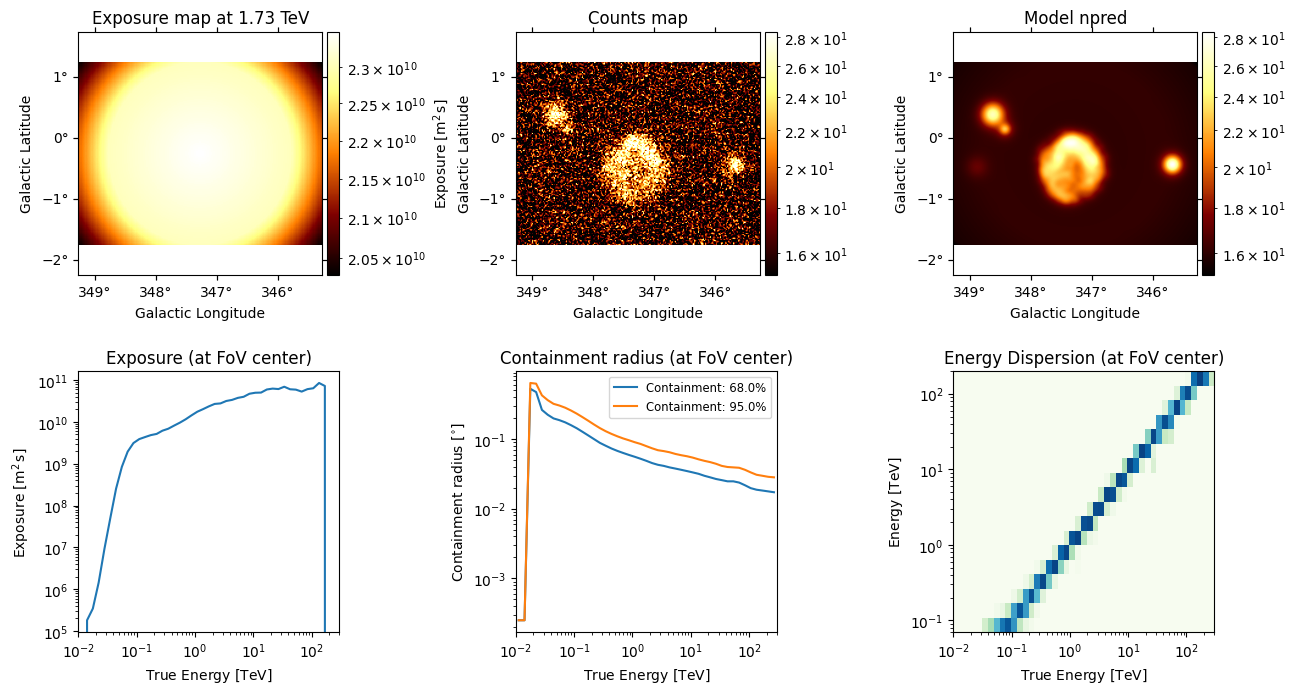

In [67]:
dataset_ctao.peek()

Let's compute the TS map in the same energy range as previouly

In [68]:
%%time
dataset_ctao.models= None #we remove the soruce model to  see the excess
ts_results_ctao = ts_estimator.run(dataset_ctao)

CPU times: user 977 ms, sys: 163 ms, total: 1.14 s
Wall time: 4.46 s


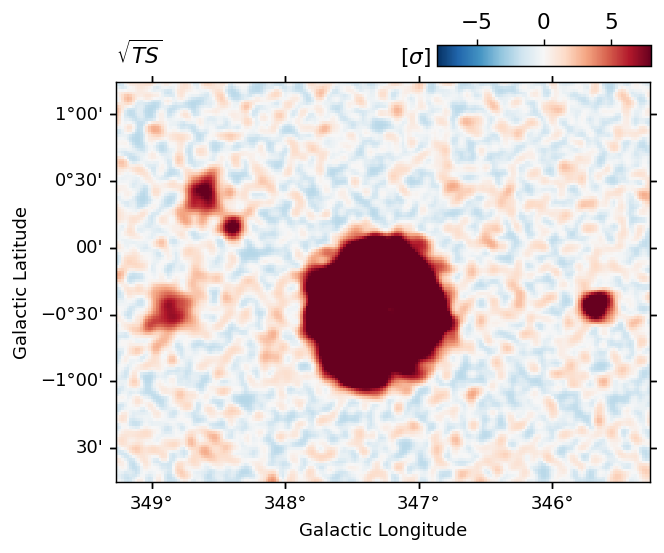

In [69]:
plot_significance_map(ts_results_ctao)

Now let's put back the models and compute the flux points for comparision

In [70]:
dataset_ctao.models = models

In [71]:
%%time
energy_edges = [0.07, 0.2, 0.5, 1, 2, 5, 10, 20, 50, 200] * u.TeV
fpe_ctao = FluxPointsEstimator(energy_edges=energy_edges, source="rxj_combined", n_jobs=3)
rxj_ctao_fp = fpe_ctao.run(dataset_ctao)


CPU times: user 167 ms, sys: 262 ms, total: 429 ms
Wall time: 7.9 s


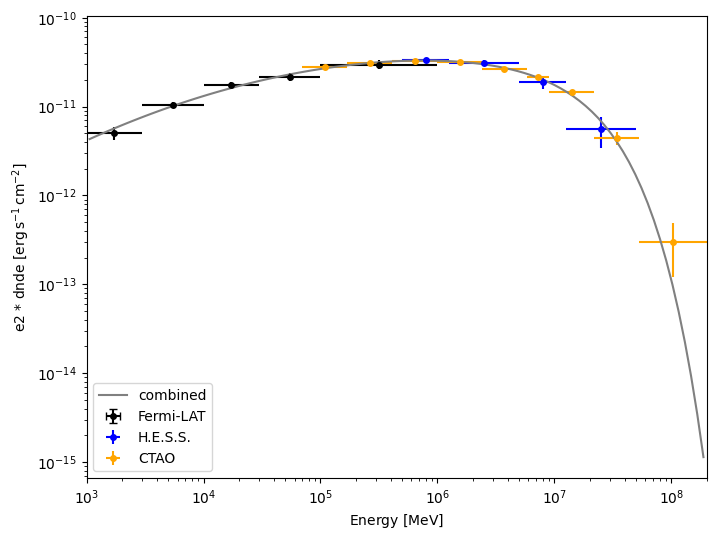

In [72]:
fig, ax = plt.subplots(figsize=(8, 6))
energy_bounds = [1, 2e5]*u.GeV

rxj_fermi_fp.plot(ax=ax, sed_type="e2dnde", color="k", label="Fermi-LAT")
rxj_hess_fp.plot(ax=ax, sed_type="e2dnde", color="b", label="H.E.S.S.")
rxj_ctao_fp.plot(ax=ax, sed_type="e2dnde", color="orange", label="CTAO")

rxj_combined.spectral_model.plot(ax=ax, energy_bounds=energy_bounds, energy_power=2, color="grey", label="combined")

plt.xlim(energy_bounds)
plt.legend()
plt.show()